* Repository github url : https://github.com/jai-mr/
* Assignment Repository : https://github.com/jai-mr/Assignment-4
* Submitted by : Jaideep Rangnekar
* Registered email id : jaideepmr@gmail.com

In [13]:
# Import all the libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [14]:
"""Net: Our Base Model for MNIST Classification
Attributes
    
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # input - 28x28x1; output - 22x22x32;
        self.conv1 = nn.Sequential(
            # RF - 3x3
            nn.Conv2d(1, 16, 3, bias=False), # 26
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            # RF - 5x5
            nn.Conv2d(16, 16, 3, bias=False), # 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            # RF - 7x7
            nn.Conv2d(16, 32, 3, bias=False), # 22
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
        )

        # translation layer
        # input - 22x22x32; output - 11x11x16
        self.trans1 = nn.Sequential(
            # RF - 7x7
            nn.Conv2d(32, 16, 1, bias=False), # 22
            nn.ReLU(),

            # RF - 14x14
            nn.MaxPool2d(2, 2), # 11
        )
        
        # input - 11x11x16; output - 7x7x16;
        self.conv2 = nn.Sequential(
            # RF - 16x16
            nn.Conv2d(16, 16, 3, bias=False), # 9
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            # RF - 18x18
            nn.Conv2d(16, 16, 3, bias=False), # 7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
        )

        # input - 7x7x16; output - 5x5x16
        self.conv3 = nn.Sequential(
            # RF - 20x20
            nn.Conv2d(16, 16, 3, padding=1, bias=False), # 5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            # RF - 22x22
            nn.Conv2d(16, 16, 3, bias=False), # 5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
        )

        # input - 5x5x16; output - 1x1x10
        self.avg_pool = nn.Sequential(
            # # RF - 22x22
            nn.Conv2d(16, 10, 1, bias=False),
            nn.AvgPool2d(5)
        )

    """forward: performs a forward pass when model(x) is called
    Params
        x: the input data
    Returns
        y: the output of the model
    """
    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)

        x = x.view(-1, 10)
        return F.log_softmax(x)

In [15]:
!pip install torchsummary
from torchsummary import summary
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# model the model to the device
model = Net().to(device)
# print the model summary when given input_size
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,608
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
        Dropout2d-12           [-1, 32, 22, 22]               0
           Conv2d-13           [-1, 16, 22, 22]             512
             ReLU-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [16]:
torch.manual_seed(1)

#batch size
batch_size = 128

# Pin Memory
# https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory.
# This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.


kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [17]:
acc = []
from tqdm import tqdm

"""train : trains a given model
Params
    model: the model to train
    device: the device to train on
    train_loader: the train data
    optimizer: the optimizer to use
    epoch: epochs to train for

Returns
    None
"""

def train(model, device, train_loader, optimizer, epoch):
    # set the model in training mode
    model.train()
    pbar = tqdm(train_loader)
    # run for all the data in train_loader
    for batch_idx, (data, target) in enumerate(pbar):
        # fetch the data and the target value
        data, target = data.to(device), target.to(device)
        # zero out the gradients
        optimizer.zero_grad()
        # forward pass the model with the data
        output = model(data)
        # compute the loss occured
        loss = F.nll_loss(output, target)
        # compute the backward gradients
        loss.backward()
        # update the optimizer params
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item():.05f} batch_id={batch_idx:05d}')

"""test: tests a given model
Params
    model: the model to test
    device: the device used for testing, cpu/gpu
    test_loader: the test data

Returns
    None
"""

def test(model, device, test_loader):
    # set the model in evaluation mode
    model.eval()
    # set the loss to zero
    test_loss = 0
    # the number of correct classifications
    correct = 0

    # turn off gradients during the testing
    with torch.no_grad():
        for data, target in test_loader:
            # move the data to device
            data, target = data.to(device), target.to(device)
            # forward pass the model and get the output
            output = model(data)
            # accumulate the loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # get the index of max log-probability
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # increment the correct prediction count if pred is correct
            correct += pred.eq(target.view_as(pred)).sum().item()

    # test loss divided by the total number of items in test dataset
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc.append(100. * correct / len(test_loader.dataset))

In [18]:
# move the model to the specified device
model = Net().to(device)

# use Stochastic Gradient Descent as the optimizer
# learning_rate=0.01 and momentum=0.9 for SGD
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# set the number of epochs to train for
N_EPOCH = 20

# run it for N_EPOCH number of times
for epoch in range(1, N_EPOCH+1):
    print('\nEpoch {} : '.format(epoch))    
    # train the model    
    train(model, device, train_loader, optimizer, epoch)
    # test the model
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 1 : 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0779, Accuracy: 9771/10000 (97.71%)


Epoch 2 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9866/10000 (98.66%)


Epoch 3 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9897/10000 (98.97%)


Epoch 4 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9890/10000 (98.90%)


Epoch 5 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9899/10000 (98.99%)


Epoch 6 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)


Epoch 7 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)


Epoch 8 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)


Epoch 9 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)


Epoch 10 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)


Epoch 11 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)


Epoch 12 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)


Epoch 13 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)


Epoch 14 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)


Epoch 15 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)


Epoch 16 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)


Epoch 17 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)


Epoch 18 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9932/10000 (99.32%)


Epoch 19 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)


Epoch 20 : 


loss=0.05391 batch_id=00468: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]



Test set: Average loss: 0.0186, Accuracy: 9951/10000 (99.51%)



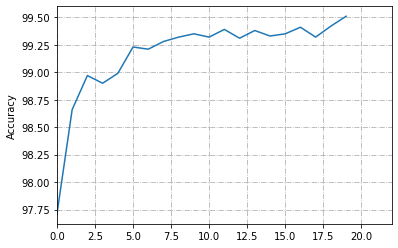

Maximum Accuracy : 99.51


In [44]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.set_xlim([0, epoch+2])
ax.grid(linestyle='-.')
plt.ylabel('Accuracy')
plt.plot(acc)
plt.show()

print("Maximum Accuracy :",max(acc))